### This script:
- reads output of control-FREEC with coverage ratios and CNVs (*_ratio.txt - here in one file & *_CNVs.p.value.txt - also in one file)
- filters out samples with non-uniform coverage, low coverage (<10x) and outliers (high number of CNVs)
- selects multiple times unrelated samples in defined groups
- compares frequencies of CNVs of the Jean-Talon between groups
#### author@aniafijarczyk

In [1]:
import pandas as pd
import glob
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import seaborn as sns

### Filtering samples with non-uniform coverage
#### Reading files

In [4]:
### File with genomic coordinates 
#coords = pd.read_csv("chromLengthConvertion.out",sep="\t",header=0)
coords = pd.DataFrame({"chrom":["ref|NC_001133|","ref|NC_001134|","ref|NC_001135|","ref|NC_001136|","ref|NC_001137|","ref|NC_001138|","ref|NC_001139|","ref|NC_001140|","ref|NC_001141|","ref|NC_001142|","ref|NC_001143|","ref|NC_001144|","ref|NC_001145|","ref|NC_001146|","ref|NC_001147|","ref|NC_001148|","ref|NC_001224|"],
                       "length":[230218,813184,316620,1531933,576874,270161,1090940,562643,439888,745751,666816,1078177,924431,784333,1091291,948066,85779],
                       "addition":[0,230218,1043402,1360022,2891955,3468829,3738990,4829930,5392573,5832461,6578212,7245028,8323205,9247636,10031969,11123260,12071326]})
### Files with coverage ratio from control-FREEC for all samples for 250 bp samples
#ratios = pd.read_csv("controlfreec_ratios.txt.gz", sep="\t",header=0,compression='gzip')
#ratios = pd.read_csv("./input_files/FileS6.txt.gz", sep="\t",header=0,compression='gzip')
ratios = pd.read_csv("./input_files/sample_FileS6.txt.gz", sep="\t",header=0,compression='gzip')

#### Getting slope of regression line for normalized coverage from center to end of chromosome

In [5]:
strains = list(set(ratios['strain']))
S = []
for strain in strains:
    df = ratios.loc[ratios['strain']==strain,:]
    dm = pd.merge(df,coords,on=['chrom'],how='left')
    dm['midpoint'] = dm['start']+125
    dm['center'] = dm['length']/2.
    dm['distance'] = abs(dm['midpoint']-dm['center'])/dm['center']
    dm['logratio'] = dm['ratio'].apply(np.log2).replace([np.inf, -np.inf], np.nan)
    dn = dm.loc[((dm['logratio'] >= -2.0) & (dm['logratio'] <= 2.0)),:].dropna()
    slope, intercept, r_value, p_value, std_err = stats.linregress(dn['distance'],dn['logratio'])
    S.append((strain,slope, intercept, r_value, p_value, std_err))
M = list(zip(*S))
dM = pd.DataFrame({'strain':M[0],'slope':M[1],'intercept':M[2],'r_value':M[3],'p_value':M[4],'std_err':M[5]})
dM.head()

,strain,slope,intercept,r_value,p_value,std_err
0,BMG,0.202279,-0.099866,0.215833,2.194976e-35,0.016099
1,A.Muntons,0.122809,0.182907,0.102054,5.630484e-09,0.021018
2,BE102,0.963313,-0.244890,0.611088,0.000000e+00,0.021993
3,TUM149,0.144055,-0.061023,0.057373,1.701338e-03,0.045866
4,A.S-04,0.116511,-0.073191,0.087003,7.000610e-07,0.023437


#### Histogram of slopes

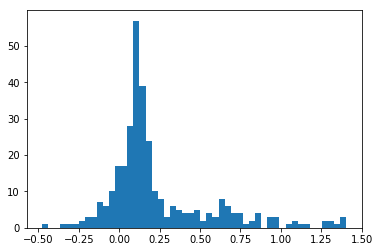

In [6]:
plt.hist(dM['slope'],bins=50)
plt.show()

#### Filtering samples with steep slope

In [7]:
dG = dM.loc[((dM['slope'] > -0.15) & (dM['slope'] < 0.15)),:]
dB = dM.loc[((dM['slope'] <= -0.15) | (dM['slope'] >= 0.15)),:]
good_coverage_samples = list(dG['strain'])
#dG[['strain']].to_csv("samples_with_good_coverage.out",sep="\t",header=True,index=False)
print("Number of all samples = "+str(len(dM)))
print("Number of good samples = "+str(len(dG)))
print("Number of filtered samples = "+str(len(dB)))

Number of all samples = 319
Number of good samples = 172
Number of filtered samples = 147


### Filtering outliers with too many CNVs

#### Reading files

In [9]:
#### Files with detected gains and losses and corresponsing p-values
#cnv_pvalues = pd.read_csv("controlfreec_cnv_pvalues.txt.gz",sep="\t",header=0,compression="gzip")
cnv_pvalues = pd.read_csv("./input_files/FileS7.txt.gz",sep="\t",header=0,compression="gzip")
#### File with metadata
meta = pd.read_csv("./input_files/table_S2.csv",sep=",",header=0)[['Strain name','Type/style','Origin','Source','Genetic group general','Coverage']]

#### Selecting good CNVs

In [10]:
strains = list(set(cnv_pvalues['strain']))
T = []
for strain in strains:
    df = cnv_pvalues.loc[cnv_pvalues['strain']==strain,:].rename(columns={'start':'beg','chr':'chrom'})
    df["length"] = df["end"]-df["beg"]
    df2 = df.loc[((df['length']>=10000) & (df['WilcoxonRankSumTestPvalue'] < 0.05)),:].reset_index().drop(columns=['index','WilcoxonRankSumTestPvalue','KolmogorovSmirnovPvalue'])
    T.append(df2)
dT = pd.concat(T)
dT.head()

,chrom,beg,end,copy number,status,strain,length
0,ref|NC_001133|,13000,24000,0,loss,BMG,11000
1,ref|NC_001133|,27250,160250,4,gain,BMG,133000
2,ref|NC_001133|,166000,198750,4,gain,BMG,32750
3,ref|NC_001135|,1250,14250,2,loss,BMG,13000
4,ref|NC_001136|,1500,15750,0,loss,BMG,14250


#### Filtering low coverage and non-uniform coverage samples

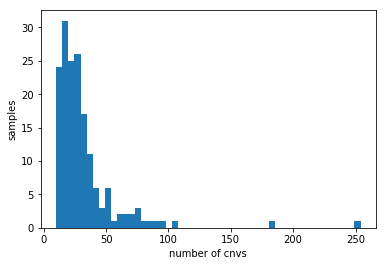

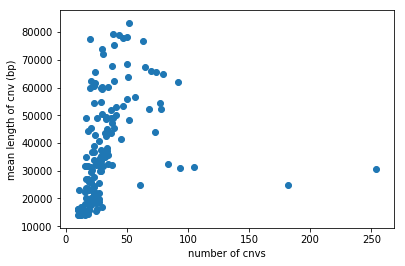

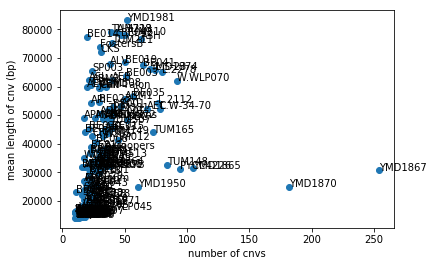

In [11]:
dm1 = pd.merge(dT,coords,on=['chrom'],how='left')
dm2 = pd.merge(dm1,meta, left_on=['strain'],right_on = ['Strain name'],how='left')
dm3 = dm2.loc[((dm2["Coverage"]>=10.0) & (dm2['strain'].isin(good_coverage_samples))),:].reset_index().drop(columns=["index"])

dg = dm3.loc[dm3['status']=="gain",:].groupby(['strain']).agg({'status':'count','length_x':'mean'}).reset_index().rename(columns={'status':'gains','length_x':'gain_len'})
dl = dm3.loc[dm3['status']=="loss",:].groupby(['strain']).agg({'status':'count','length_x':'mean'}).reset_index().rename(columns={'status':'losses','length_x':'loss_len'})
dgl = pd.merge(dg,dl,on=['strain'],how='left')
dgl['cnv'] = dgl['gains'] + dgl['losses']
dgl['cnv_len'] = dgl.apply(lambda x:np.mean([x['gain_len'],x['loss_len']]), axis=1)
dgl.head()

plt.hist(dgl['cnv'],bins=50)
plt.xlabel('number of cnvs')
plt.ylabel('samples')

dgl.plot.scatter(x = 'cnv', y = 'cnv_len')
plt.scatter(dgl['cnv'],dgl['cnv_len'])
plt.xlabel('number of cnvs')
plt.ylabel('mean length of cnv (bp)')

fig, ax = plt.subplots()
ax.scatter(dgl['cnv'], dgl['cnv_len'])
ax.set_xlabel('number of cnvs')
ax.set_ylabel('mean length of cnv (bp)')
for i, txt in enumerate(list(dgl['strain'])):
    ax.annotate(txt, (list(dgl['cnv'])[i], list(dgl['cnv_len'])[i]))

In [12]:
dout = dgl.loc[((dgl['cnv'] > 70) & (dgl['cnv_len'] < 50000)),:]
outliers = list(dout['strain'])
dm4 = dm3.loc[~dm3['strain'].isin(outliers),:].reset_index().drop(columns=['index'])
print("Number of samples = "+str(len(set(dm3['strain']))))
print("Number of filtered outliers = "+str(len(dout)))
print("Number of good samples = "+str(len(set(dm4['strain']))))

Number of samples = 166
Number of filtered outliers = 6
Number of good samples = 160


#### Setting groups

In [13]:
# Setting group
dm4['source_genetic'] = dm4.apply(lambda x: str(x['Source'])+"_"+str(x['Genetic group general']).replace("/","."), axis=1)
# Setting order order for all strains
dO = dm4[['Source','Genetic group general','strain']].sort_values(by=['Source','Genetic group general','strain']).drop_duplicates().reset_index()[['strain']]
dO['order'] = range(len(dO['strain']))
dm5 = pd.merge(dm4,dO, on=['strain'],how='left')

### Getting sets of unrelated samples

In [14]:
# Kinship matrix file can be generated with the script: calculate_IBS_IBD.R
rkin = pd.read_csv("./input_files/IBDKINGmethod_kinship_matrix.out",sep=",",header=0)
kin = rkin.reset_index()
kinlin = kin.melt(id_vars=['index'],value_vars=[c for c in kin if c!='index'])
dfm = pd.merge(dm5[['strain','source_genetic']].drop_duplicates(), kinlin, left_on = ['strain'], 
               right_on = ['index'], how='left')
dff = dfm.loc[dfm['index']!=dfm['variable'],:]
dff.head()

,strain,source_genetic,index,variable,value
0,A.Muntons,Beer_Beer.baking,A.Muntons,A.1007,0.000000
1,A.Muntons,Beer_Beer.baking,A.Muntons,A.1187,0.195821
2,A.Muntons,Beer_Beer.baking,A.Muntons,A.1728,0.091171
3,A.Muntons,Beer_Beer.baking,A.Muntons,A.1945,0.099815
4,A.Muntons,Beer_Beer.baking,A.Muntons,A.1968,0.070160


#### Selecting unrelated samples from each group 20 x

In [15]:
samples = list(set(dff['index']))
sets = 20
G = []
i = sets
ds = dm5[['strain','source_genetic']].drop_duplicates()
selected_groups = ['Beer_Beer.baking','Baking_Beer.baking','Wild_Beer.baking','Beer_Beer2','Beer_Ale2',
                   'Beer_Ale1','Wine_Wine']

while i > 0:
    print(i)
    sampled = random.sample(samples,len(samples))
    bads = []
    goods = []
    for samp in sampled:
        if samp not in bads:
            dsel = dff.loc[(dff['index']==samp),:]
            variables = list(dsel['variable'])
            for samp2 in variables:
                if samp2 not in bads:
                    dsel2 = dsel.loc[dsel['variable']==samp2,['value']].iloc[0,0]
                    if dsel2 <= 0.18:
                        g = samp, samp2, dsel2
                        goods.append(g)
                    else:
                        bads.append(samp2)
    gsamples = list(set([ele[0] for ele in goods]))
    dsf = ds.loc[ds['strain'].isin(gsamples),:].reset_index().drop(columns=['index'])
    # check if all important groups are there
    gr = list(set(dsf['source_genetic']))
    T = []
    for ele in selected_groups:
        if ele in gr:
            t = 1
            T.append(t)
        else:
            t = 0
            T.append(t)
    if sum(T) == len(selected_groups):
        #dsf.to_csv('unrelated_samples_set_'+str(i)+'.txt',sep='\t',header=True, index=False)
        dsf['set'] = i
        G.append(dsf)
        i-=1
    else:
        i=i

20
19
18
17
16
15
14
13
13
13
12
11
10
9
9
9
8
7
6
5
4
3
2
1


#### Summary of number of samples per group across sets

In [156]:
dGroups = pd.concat(G)
dF = dGroups.groupby(['source_genetic','set']).agg({'strain':'count'}).reset_index()
dF.head()
#dF.groupby(['source_genetic']).agg({'strain':['min','max']}).reset_index()
#dF.to_csv('filterRelatives_strains_count.tab',sep='\t',header=True,index=False)

,source_genetic,set,strain
0,Baking_Beer.baking,1,6
1,Baking_Beer.baking,2,9
2,Baking_Beer.baking,3,6
3,Baking_Beer.baking,4,8
4,Baking_Beer.baking,5,5


#### Gathering CNV results in separate folders for each set and group

In [16]:
for gset in G:
    tab = gset.loc[gset['source_genetic'].isin(selected_groups),:]
    setnum = tab.iloc[0,2]
    print(setnum)
    gr = tab.groupby(["source_genetic"]).agg({'strain':lambda x: [i for i in x]}).reset_index()
    cmd1 = 'mkdir ./gainloss_set'+str(setnum)
    os.system(cmd1)
    for index, row in gr.iterrows():
        lista = row['strain']
        group_name = row['source_genetic'].replace("/",".")
        if lista:
            cmd = 'mkdir ./gainloss_set'+str(setnum)+'/group_'+group_name
            os.system(cmd)
            for ele in lista:              
                cnv = dT.loc[dT['strain']==ele,:]
                cnv_gain = cnv.loc[cnv['status']=='gain',:]
                cnv_loss = cnv.loc[cnv['status']=='loss',:]
                cnv_gain.to_csv("./gainloss_set"+str(setnum)+"/group_"+group_name+"/strain_"+ele+"_rmdup.bam_CNVs.p.value_gain.bed",sep="\t",header=False,index=False,columns=["chrom","beg","end"])
                cnv_loss.to_csv("./gainloss_set"+str(setnum)+"/group_"+group_name+"/strain_"+ele+"_rmdup.bam_CNVs.p.value_loss.bed",sep="\t",header=False,index=False,columns=["chrom","beg","end"])

20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


### Analysing CNVs with bedtools
#### Getting files with numbers of gains and losses of 250 bp windows within groups
```sh

fileA=chromLengthConvertion.fai   # genome fasta fai file
fileB=genome_windows_250.bed      # bed file with 250 bp windows
fileC=cnv_beer_bb_gains.bed       # coordinates of gains in Beer/baking group
fileD=cnv_beer_bb_losses.bed      # coordinates of losses in Beer/baking group

for s in {1..20}
  do
  groups=./gainloss_set${s}/group_*
  echo 'set_'$s
  for group in $groups
    do
    nameis=$(echo ${group} | cut -d"/" -f3 | sed 's/group_//g')
    echo $nameis
    cat ./gainloss_set${s}/group_${nameis}/strain_*_gain.bed | sort -k1,1 -k2,2n > \
    ./gainloss_set${s}/temp_gains.bed 
    bedtools genomecov -i ./gainloss_set${s}/temp_gains.bed -g ${fileA} -bga > \
    ./gainloss_set${s}/cov_gain_${nameis}.out
    bedtools intersect -a $fileB -b ./gainloss_set${s}/cov_gain_${nameis}.out -wao \
    | awk -v var=$nameis '{print $1"\t"$2"\t"$3"\t"$7"\tgain\t"var}' > \
    ./gainloss_set${s}/cov_windows_gain_${nameis}.out
    bedtools intersect -a $fileC -b ./gainloss_set${s}/cov_windows_gain_${nameis}.out -wao > \
    ./gainloss_set${s}/cnv_gain_${nameis}.out
    rm ./gainloss_set${s}/cov_gain_${nameis}.out
    rm ./gainloss_set${s}/cov_windows_gain_${nameis}.out

    cat ./gainloss_set${s}/group_${nameis}/strain_*_loss.bed | sort -k1,1 -k2,2n > \
    ./gainloss_set${s}/temp_loss.bed 
    bedtools genomecov -i ./gainloss_set${s}/temp_loss.bed -g ${fileA} -bga > \
    ./gainloss_set${s}/cov_loss_${nameis}.out
    bedtools intersect -a $fileB -b ./gainloss_set${s}/cov_loss_${nameis}.out -wao \
    | awk -v var=$nameis '{print $1"\t"$2"\t"$3"\t"$7"\tloss\t"var}' > \
    ./gainloss_set${s}/cov_windows_loss_${nameis}.out
    bedtools intersect -a $fileD -b ./gainloss_set${s}/cov_windows_loss_${nameis}.out -wao \
    > ./gainloss_set${s}/cnv_loss_${nameis}.out
    rm ./gainloss_set${s}/cov_loss_${nameis}.out
    rm ./gainloss_set${s}/cov_windows_loss_${nameis}.out
    done
  cat ./gainloss_set${s}/cnv_gain_*.out > ./gainloss_set${s}/cnv_gain.txt
  cat ./gainloss_set${s}/cnv_loss_*.out > ./gainloss_set${s}/cnv_loss.txt
  done
```

### Getting frequencies of gains and losses in groups
#### Reading files

In [163]:
gains = glob.glob("./gainloss_set*/cnv_gain.txt")
losses = glob.glob("./gainloss_set*/cnv_loss.txt")

#### Analysing gains

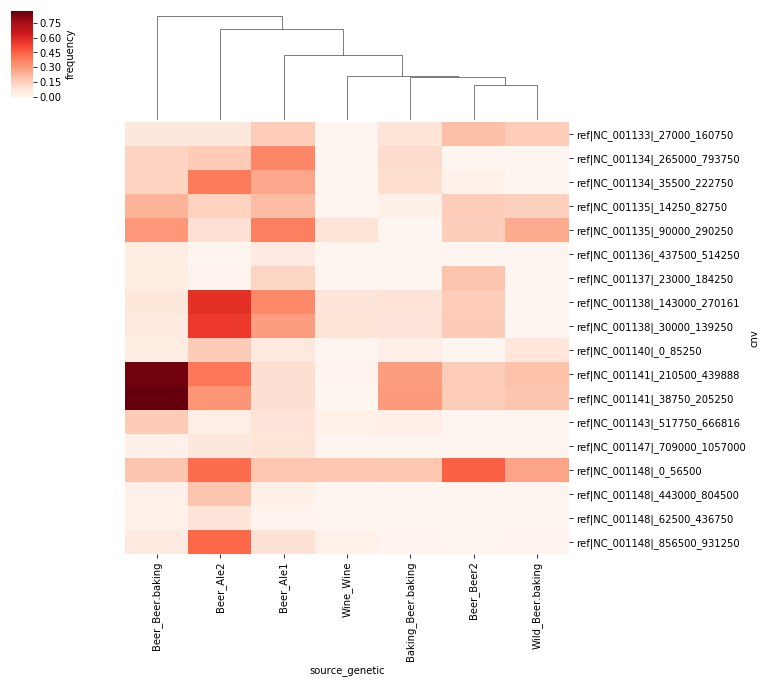

In [182]:
# Concatenating files from all sets
Gains = []
for fgain in gains:
    getset = fgain.split('/')[1].replace('gainloss_set','')
    dg = pd.read_csv(fgain, sep="\t", header=None, names=['chrom','start','stop','chrom2','winstart','winstop',
                                                         'cn','status','source_genetic','len'])
    dg['set'] = int(getset)
    Gains.append(dg)
dGains = pd.concat(Gains)

# Merging all gains with information on number of strains
dGM = pd.merge(dGains, dF, on = ['source_genetic','set'], how='left')
dGM['freq'] = dGM['cn']/dGM['strain']
dGM['cnv_len'] = dGM['stop'] - dGM['start']

# Getting frequencies
dGG = dGM.groupby(['chrom','start','stop','set','source_genetic']).agg({'len':'sum','freq':'mean','cnv_len':'mean'}).fillna(0).reset_index()
dGG['len_frac'] = dGG['len']/dGG['cnv_len']
dGG['freq2'] = dGG.apply(lambda x: x['freq'] if x['len_frac'] >= 0.75 else 0.0, axis=1)

# Calculating mean and sd across sets
dsetG = dGG.groupby(['chrom','start','stop','source_genetic']).agg({'freq2':[np.mean,np.std]}).reset_index()
dsetG.columns = dsetG.columns.map(''.join)

# Plotting heatmap
dsetG['cnv'] = dsetG.apply(lambda x: x['chrom']+"_"+str(x['start'])+"_"+str(x['stop']),axis=1)
tabG = pd.pivot_table(dsetG,values='freq2mean',index='cnv',columns='source_genetic')
g = sns.clustermap(tabG, row_cluster=False,cmap="Reds",cbar_kws={'label':'frequency'})
#g.savefig("getFrequency_heatmap_gains.png",format="png")

#### Analysing losses

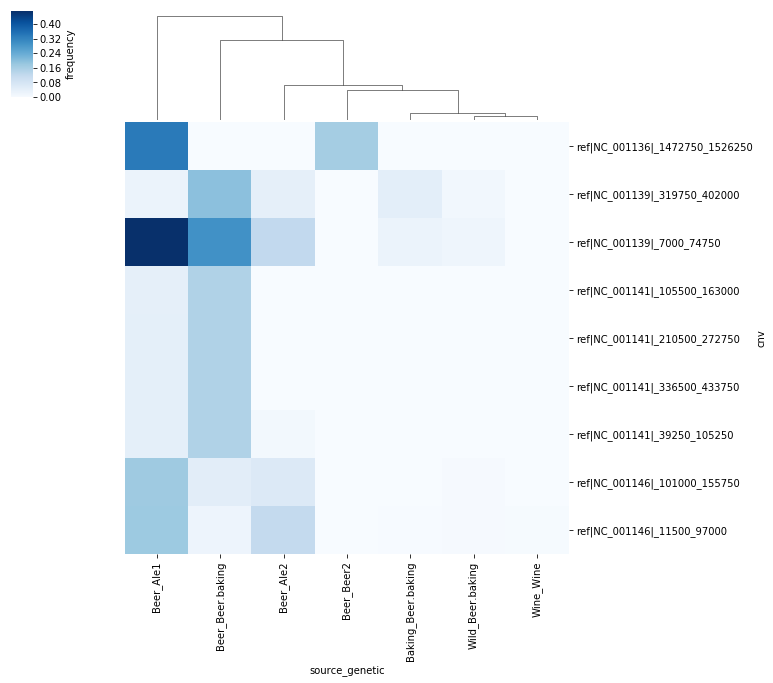

In [184]:
# Concatenating files from all sets
Losses = []
for floss in losses:
    getset = floss.split('/')[1].replace('gainloss_set','')
    dl = pd.read_csv(floss, sep="\t", header=None, names=['chrom','start','stop','chrom2','winstart','winstop',
                                                         'cn','status','source_genetic','len'])
    dl['set'] = int(getset)
    Losses.append(dl)
dLoss = pd.concat(Losses)

# Merging all gains with information on number of strains
dLM = pd.merge(dLoss, dF, on = ['source_genetic','set'], how='left')
dLM['freq'] = dLM['cn']/dLM['strain']
dLM['cnv_len'] = dLM['stop'] - dLM['start']

# Getting frequencies
dLL = dLM.groupby(['chrom','start','stop','set','source_genetic']).agg({'len':'sum','freq':'mean','cnv_len':'mean'}).fillna(0).reset_index()
dLL['len_frac'] = dLL['len']/dLL['cnv_len']
dLL['freq2'] = dLL.apply(lambda x: x['freq'] if x['len_frac'] >= 0.75 else 0.0, axis=1)

# Calculating mean and sd across sets
dsetL = dLL.groupby(['chrom','start','stop','source_genetic']).agg({'freq2':[np.mean,np.std]}).reset_index()
dsetL.columns = dsetL.columns.map(''.join)


# Plotting heatmap
dsetL['cnv'] = dsetL.apply(lambda x: x['chrom']+"_"+str(x['start'])+"_"+str(x['stop']),axis=1)
tabL = pd.pivot_table(dsetL,values='freq2mean',index='cnv',columns='source_genetic')
tabL.head()
l = sns.clustermap(tabL, row_cluster=False,cmap="Blues",cbar_kws={'label':'frequency'})
#l.savefig("getFrequency_heatmap_losses.png",format="png")
